In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 30)

In [39]:
df = pd.read_csv("data/df_post_EDA.csv", index_col=0)
df.head()

,user_ID,chapter_ID,relative_renewal_date,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,year_of_membership,chapter_size,chapter_retention_rate,chapter_growth_rate,seat_popularity_rate,total_meetings,wont_renew
0,0,31,2016-04-01,33,0,0,1,0,21,7,33,32,1,37,129784,45,0,32,0.315789,1.421053,0.076923,34,0
1,2,18,2017-05-01,33,2,2,0,0,6,17,11,22,1,26,9285,1,0,34,0.718750,1.093750,0.266667,37,0
2,2,18,2018-05-01,35,1,0,0,2,6,24,19,36,1,20,7263,10,1,21,0.424242,0.636364,0.210526,38,0
3,2,18,2019-05-01,36,0,0,0,1,9,8,23,19,3,28,1860,31,2,22,0.739130,1.217391,0.263158,37,0
4,2,18,2020-05-01,33,1,0,0,3,10,13,19,47,4,30,6668,16,3,26,0.760000,1.120000,0.277778,37,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2191 entries, 0 to 2428
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_ID                 2191 non-null   int64  
 1   chapter_ID              2191 non-null   int64  
 2   relative_renewal_date   2191 non-null   object 
 3   P                       2191 non-null   int64  
 4   A                       2191 non-null   int64  
 5   L                       2191 non-null   int64  
 6   M                       2191 non-null   int64  
 7   S                       2191 non-null   int64  
 8   RGI                     2191 non-null   int64  
 9   RGO                     2191 non-null   int64  
 10  RRI                     2191 non-null   int64  
 11  RRO                     2191 non-null   int64  
 12  V                       2191 non-null   int64  
 13  1-2-1                   2191 non-null   int64  
 14  TYFCB                   2191 non-null   

### Drop & split

In [41]:
df.drop(["user_ID", "relative_renewal_date"], axis=1, inplace=True)

# Prepare data
## Feature multiplication

In [42]:
df.columns.tolist()

['chapter_ID',
 'P',
 'A',
 'L',
 'M',
 'S',
 'RGI',
 'RGO',
 'RRI',
 'RRO',
 'V',
 '1-2-1',
 'TYFCB',
 'CEU',
 'year_of_membership',
 'chapter_size',
 'chapter_retention_rate',
 'chapter_growth_rate',
 'seat_popularity_rate',
 'total_meetings',
 'wont_renew']

In [43]:
df["P_by_A"] = df["P"] / (df["A"] + 1)
df["P_by_M"] = df["P"] / (df["M"] + 1)
df["P_by_S"] = df["P"] / (df["S"] + 1)
df["P_by_total"] = df["P"] / df["total_meetings"]
df["A_by_total"] = df["A"] / df["total_meetings"]
df["M_by_total"] = df["M"] / df["total_meetings"]

df["P_tim_retention"] = df["P"] * df["chapter_retention_rate"]
df["P_tim_growth"] = df["P"] * df["chapter_growth_rate"]
df["P_tim_popularity"] = df["P"] * df["seat_popularity_rate"]
df["P_tim_V"] = df["P"] * df["V"]
df["P2_tim_V"] = df["P"]**2 * df["V"]
df["P_tim_TYFCB"] = df["P"] * df["TYFCB"]

df["year_tim_retention"] = df["year_of_membership"] * df["chapter_retention_rate"]

df["P2"] = df["P"]**2

columns_list = df.columns.tolist()
columns_list.remove("wont_renew")

columns_list+= ["wont_renew"]
df = df[columns_list]

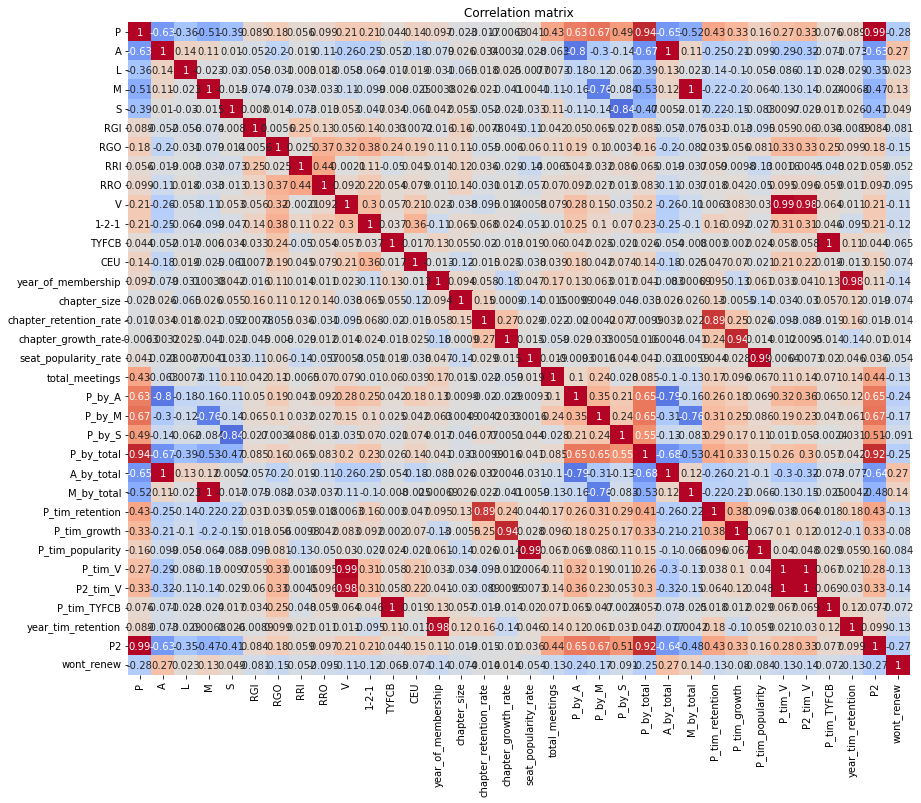

In [44]:
corr = df.iloc[:,1:].corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, cbar=False, annot=True, vmin=-1, vmax=1, center=0, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

In [45]:
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.linear_model import LogisticRegression

X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.8,
    missing_values="ignore",
    selection_method="model_performance",
    estimator=LogisticRegression(max_iter=2000),
)

X = tr.fit_transform(X, y)

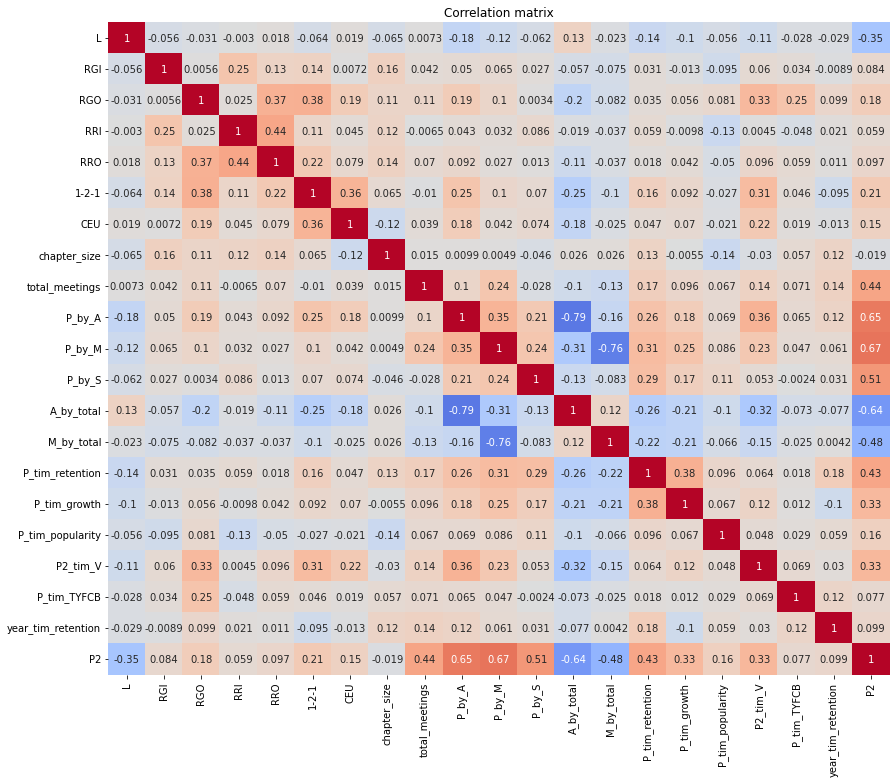

In [46]:
corr = X.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, cbar=False, annot=True, vmin=-1, vmax=1, center=0, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

# Feature Selection

First remove highly correlated features

Then use top 4 AUC performing models:
- Logistic Regression
- Random Forest
- XGBoost
- CatBoost

to complete recursive feature selection.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks, NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

## Feature selection: Logistic Regression

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [49]:
model = LogisticRegression(max_iter=2000)
model.fit(X_resampled, y_resampled)

y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(datetime.datetime.now(), "ROC AuC all features", auc)

2021-12-23 15:54:38.119634 ROC AuC all features 0.6999269005847952


In [50]:
df_feature_importance = pd.DataFrame({'feature_importance': np.abs(model.coef_)[0],
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
nr_features = df_feature_importance.shape[0]
df_feature_importance.to_csv(f'pick_{nr_features}_features_logreg.csv')
list_features = df_feature_importance["feature_name"].tolist()
df_results = pd.DataFrame({'nr_features': nr_features,
                           'list_features': [list_features],
                           'auc': auc})

In [51]:
df_results.head()

,nr_features,list_features,auc
0,21,"[A_by_total, year_tim_retention, P_tim_popular...",0.699927


In [52]:
for nr_features in range(X_resampled.shape[1] - 1, 2, -1):
    df_feature_importance = df_feature_importance.head(nr_features)
    list_features = df_feature_importance["feature_name"].tolist()
    
    X_resampled = X_resampled[list_features]
    X_test = X_test[list_features]
    model.fit(X_resampled, y_resampled)
    y_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba[:,1])
    print(datetime.datetime.now(), nr_features, "features - ROC AuC", auc)
    
    df_feature_importance = pd.DataFrame({'feature_importance': np.abs(model.coef_)[0],
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
    df_feature_importance.to_csv(f'pick_{nr_features}_features_logreg.csv')
    df_results = df_results.append({'nr_features': nr_features, 'list_features': [list_features], 'auc': auc}, ignore_index=True)

df_results.to_csv(f"feature_selection_results_logreg.csv")

2021-12-23 15:54:40.295605 20 features - ROC AuC 0.7001949317738791
2021-12-23 15:54:40.309608 19 features - ROC AuC 0.7001461988304094
2021-12-23 15:54:40.323616 18 features - ROC AuC 0.6996345029239767
2021-12-23 15:54:40.337619 17 features - ROC AuC 0.6988304093567251
2021-12-23 15:54:40.350622 16 features - ROC AuC 0.6994639376218323
2021-12-23 15:54:40.363625 15 features - ROC AuC 0.6972709551656919
2021-12-23 15:54:40.375617 14 features - ROC AuC 0.699561403508772
2021-12-23 15:54:40.388631 13 features - ROC AuC 0.6962962962962963
2021-12-23 15:54:40.400633 12 features - ROC AuC 0.695906432748538
2021-12-23 15:54:40.411636 11 features - ROC AuC 0.6983918128654971
2021-12-23 15:54:40.422638 10 features - ROC AuC 0.7001218323586745
2021-12-23 15:54:40.434636 9 features - ROC AuC 0.6943226120857701
2021-12-23 15:54:40.445644 8 features - ROC AuC 0.692738791423002
2021-12-23 15:54:40.456628 7 features - ROC AuC 0.6883040935672515
2021-12-23 15:54:40.467634 6 features - ROC AuC 0.7034

## Feature selection: Random Forest

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [54]:
model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)

y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(datetime.datetime.now(), "ROC AuC all features", auc)

2021-12-23 15:54:47.789810 ROC AuC all features 0.6963572124756335


In [55]:
df_feature_importance = pd.DataFrame({'feature_importance': model.feature_importances_,
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
nr_features = df_feature_importance.shape[0]
df_feature_importance.to_csv(f'pick_{nr_features}_features_rf.csv')
list_features = df_feature_importance["feature_name"].tolist()
df_results = pd.DataFrame({'nr_features': nr_features,
                           'list_features': [list_features],
                           'auc': auc})

In [56]:
for nr_features in range(X_resampled.shape[1] - 1, 2, -1):
    df_feature_importance = df_feature_importance.head(nr_features)
    list_features = df_feature_importance["feature_name"].tolist()
    
    X_resampled = X_resampled[list_features]
    X_test = X_test[list_features]
    model.fit(X_resampled, y_resampled)
    y_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba[:,1])
    print(datetime.datetime.now(), nr_features, "features - ROC AuC", auc)
    
    df_feature_importance = pd.DataFrame({'feature_importance': model.feature_importances_,
                                      'feature_name': model.feature_names_in_}).sort_values("feature_importance", ascending=False)
    df_feature_importance.to_csv(f'pick_{nr_features}_features_rf.csv')
    df_results = df_results.append({'nr_features': nr_features, 'list_features': [list_features], 'auc': auc}, ignore_index=True)

df_results.to_csv(f"feature_selection_results_rf.csv")

2021-12-23 15:54:48.206174 20 features - ROC AuC 0.6925194931773879
2021-12-23 15:54:48.535023 19 features - ROC AuC 0.7043372319688109
2021-12-23 15:54:48.885801 18 features - ROC AuC 0.6996954191033138
2021-12-23 15:54:49.249940 17 features - ROC AuC 0.6940180311890838
2021-12-23 15:54:49.611704 16 features - ROC AuC 0.6988425925925926
2021-12-23 15:54:49.918759 15 features - ROC AuC 0.6924585769980507
2021-12-23 15:54:50.228524 14 features - ROC AuC 0.6999390838206627
2021-12-23 15:54:50.536593 13 features - ROC AuC 0.6810672514619883
2021-12-23 15:54:50.851683 12 features - ROC AuC 0.6835526315789473
2021-12-23 15:54:51.160450 11 features - ROC AuC 0.6746588693957115
2021-12-23 15:54:51.480210 10 features - ROC AuC 0.6850755360623781
2021-12-23 15:54:51.797282 9 features - ROC AuC 0.6858552631578949
2021-12-23 15:54:52.063341 8 features - ROC AuC 0.6798123781676413
2021-12-23 15:54:52.329402 7 features - ROC AuC 0.6861842105263158
2021-12-23 15:54:52.597380 6 features - ROC AuC 0.6

## Feature selection: XGBoost

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [78]:
model = xgb.XGBClassifier(eval_metric="auc", n_jobs=-1, random_state=42, use_label_encoder=False)
model.fit(X_resampled, y_resampled)

y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(datetime.datetime.now(), "ROC AuC all features", auc)

2021-12-23 16:00:26.232977 ROC AuC all features 0.6729288499025341


In [79]:
df_feature_importance = pd.DataFrame({'feature_importance': list(model.get_booster().get_score(importance_type="gain").values()),
                                      'feature_name': list(model.get_booster().get_score(importance_type="gain").keys())}).sort_values("feature_importance", ascending=False)
nr_features = df_feature_importance.shape[0]
df_feature_importance.to_csv(f'pick_{nr_features}_features_xgb.csv')
list_features = df_feature_importance["feature_name"].tolist()
df_results = pd.DataFrame({'nr_features': nr_features,
                           'list_features': [list_features],
                           'auc': auc})

In [80]:
df_feature_importance.head()

,feature_importance,feature_name
0,9.215756,P2
8,1.783695,A_by_total
14,1.617129,P_by_A
2,1.546007,P_tim_TYFCB
10,1.534730,year_tim_retention


In [81]:
for nr_features in range(X_resampled.shape[1] - 1, 2, -1):
    df_feature_importance = df_feature_importance.head(nr_features)
    list_features = df_feature_importance["feature_name"].tolist()
    
    X_resampled = X_resampled[list_features]
    X_test = X_test[list_features]
    model.fit(X_resampled, y_resampled)
    y_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba[:,1])
    print(datetime.datetime.now(), nr_features, "features - ROC AuC", auc)
    
    df_feature_importance = pd.DataFrame({'feature_importance': list(model.get_booster().get_score(importance_type="gain").values()),
                                      'feature_name': list(model.get_booster().get_score(importance_type="gain").keys())}).sort_values("feature_importance", ascending=False)
    df_feature_importance.to_csv(f'pick_{nr_features}_features_xgb.csv')
    df_results = df_results.append({'nr_features': nr_features, 'list_features': [list_features], 'auc': auc}, ignore_index=True)

df_results.to_csv(f"feature_selection_results_xgb.csv")

2021-12-23 16:00:34.078351 20 features - ROC AuC 0.6966374269005847
2021-12-23 16:00:34.257031 19 features - ROC AuC 0.6511939571150098
2021-12-23 16:00:34.450718 18 features - ROC AuC 0.6650828460038987
2021-12-23 16:00:34.627758 17 features - ROC AuC 0.6769493177387915
2021-12-23 16:00:34.824802 16 features - ROC AuC 0.6749269005847953
2021-12-23 16:00:35.010881 15 features - ROC AuC 0.6724658869395712
2021-12-23 16:00:35.204923 14 features - ROC AuC 0.6884259259259259
2021-12-23 16:00:35.370960 13 features - ROC AuC 0.662061403508772
2021-12-23 16:00:35.530996 12 features - ROC AuC 0.6679093567251462
2021-12-23 16:00:35.684030 11 features - ROC AuC 0.6754385964912281
2021-12-23 16:00:35.842066 10 features - ROC AuC 0.6948343079922028
2021-12-23 16:00:35.997101 9 features - ROC AuC 0.6597709551656921
2021-12-23 16:00:36.152189 8 features - ROC AuC 0.6378898635477582
2021-12-23 16:00:36.303862 7 features - ROC AuC 0.6542884990253411
2021-12-23 16:00:36.452896 6 features - ROC AuC 0.65

## Feature selection: CatBoost

In [20]:
X = df.drop(["wont_renew"], axis=1).copy()
y = df["wont_renew"].copy()

tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.8,
    missing_values="ignore",
    selection_method="model_performance",
    estimator=LogisticRegression(max_iter=2000),
)

X = tr.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

X_train["chapter_ID"] = X_train["chapter_ID"].astype("str")
X_test["chapter_ID"] = X_test["chapter_ID"].astype("str")

In [21]:
from catboost import Pool

model = CatBoostClassifier(early_stopping_rounds=20)
pool_train = Pool(X_train, y_train, cat_features=["chapter_ID"])
pool_test = Pool(X_test, y_test, cat_features=["chapter_ID"])
model.fit(pool_train, verbose=0)

y_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_proba[:,1])
print(datetime.datetime.now(), "ROC AuC all features", auc)

2021-12-23 15:19:44.040345 ROC AuC all features 0.7106237816764133


In [22]:
df_feature_importance = pd.DataFrame({'feature_importance': model.get_feature_importance(pool_train),
                                      'feature_name': X_train.columns}).sort_values("feature_importance", ascending=False)
nr_features = df_feature_importance.shape[0]
df_feature_importance.to_csv(f'pick_{nr_features}_features_catboost.csv')
list_features = df_feature_importance["feature_name"].tolist()
df_results = pd.DataFrame({'nr_features': nr_features,
                           'list_features': [list_features],
                           'auc': auc})

In [23]:
df_feature_importance.head()

,feature_importance,feature_name
18,8.650409,P_tim_popularity
20,7.018866,P_tim_TYFCB
16,6.710790,P_tim_retention
7,6.044554,1-2-1
0,5.854816,chapter_ID


In [24]:
for nr_features in range(X_train.shape[1] - 1, 2, -1):
    df_feature_importance = df_feature_importance.head(nr_features)
    list_features = df_feature_importance["feature_name"].tolist()
    
    X_train = X_train[list_features]
    X_test = X_test[list_features]
    
    if "chapter_ID" in list_features:
        pool_train = Pool(X_train, y_train, cat_features=["chapter_ID"])
        pool_test = Pool(X_test, y_test, cat_features=["chapter_ID"])
    else:
        pool_train = Pool(X_train, y_train)
        pool_test = Pool(X_test, y_test)
    
    model.fit(pool_train, verbose=0)

    y_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_proba[:,1])
    print(datetime.datetime.now(), nr_features, "features - ROC AuC", auc)
    
    df_feature_importance = pd.DataFrame({'feature_importance': model.get_feature_importance(pool_train),
                                      'feature_name': X_train.columns}).sort_values("feature_importance", ascending=False)
    df_feature_importance.to_csv(f'pick_{nr_features}_features_catboost.csv')
    df_results = df_results.append({'nr_features': nr_features, 'list_features': [list_features], 'auc': auc}, ignore_index=True)

df_results.to_csv(f"feature_selection_results_catboost.csv")

2021-12-23 15:20:07.282581 21 features - ROC AuC 0.7250730994152046
2021-12-23 15:20:30.717660 20 features - ROC AuC 0.7133528265107213
2021-12-23 15:20:53.664030 19 features - ROC AuC 0.7087231968810915
2021-12-23 15:21:17.029092 18 features - ROC AuC 0.6952729044834307
2021-12-23 15:21:38.626626 17 features - ROC AuC 0.6951267056530215
2021-12-23 15:22:01.746673 16 features - ROC AuC 0.7011452241715401
2021-12-23 15:22:24.374360 15 features - ROC AuC 0.6992690058479533
2021-12-23 15:22:47.186987 14 features - ROC AuC 0.6943469785575049
2021-12-23 15:23:12.220301 13 features - ROC AuC 0.6946150097465886
2021-12-23 15:23:38.301077 12 features - ROC AuC 0.6896686159844054
2021-12-23 15:24:01.108367 11 features - ROC AuC 0.6783382066276803
2021-12-23 15:24:26.665814 10 features - ROC AuC 0.6768518518518517
2021-12-23 15:24:51.152595 9 features - ROC AuC 0.6792153996101365
2021-12-23 15:25:13.250761 8 features - ROC AuC 0.6894005847953215
2021-12-23 15:25:37.097334 7 features - ROC AuC 0.

### Get results

In [82]:
df_results_cat = pd.read_csv("feature_selection_results_catboost.csv", index_col=0)
df_results_logreg = pd.read_csv("feature_selection_results_logreg.csv", index_col=0)
df_results_rf = pd.read_csv("feature_selection_results_rf.csv", index_col=0)
df_results_xgb = pd.read_csv("feature_selection_results_xgb.csv", index_col=0)
df_results_rf.head()

,nr_features,list_features,auc
0,21,"['P_tim_TYFCB', 'P_tim_popularity', 'P_tim_ret...",0.696357
1,20,"[['P_tim_TYFCB', 'P_tim_popularity', 'P_tim_re...",0.692519
2,19,"[['P_tim_TYFCB', 'P_tim_retention', 'P_tim_pop...",0.704337
3,18,"[['P_tim_TYFCB', 'P_tim_retention', 'P_tim_pop...",0.699695
4,17,"[['P_tim_TYFCB', 'P_tim_popularity', 'P_tim_re...",0.694018


In [83]:
df_results_cat.drop(["list_features"], axis=1, inplace=True)
df_results_logreg.drop(["list_features"], axis=1, inplace=True)
df_results_rf.drop(["list_features"], axis=1, inplace=True)
df_results_xgb.drop(["list_features"], axis=1, inplace=True)

df_results_cat.rename({"auc": "auc_catboost"}, axis=1, inplace=True)
df_results_logreg.rename({"auc": "auc_logreg"}, axis=1, inplace=True)
df_results_rf.rename({"auc": "auc_rf"}, axis=1, inplace=True)
df_results_xgb.rename({"auc": "auc_xgb"}, axis=1, inplace=True)

In [84]:
df_results = df_results_cat.merge(df_results_logreg, how="left", on="nr_features")
df_results = df_results.merge(df_results_rf, how="left", on="nr_features")
df_results = df_results.merge(df_results_xgb, how="left", on="nr_features")

df_results.head()

,nr_features,auc_catboost,auc_logreg,auc_rf,auc_xgb
0,22,0.710624,NaN,NaN,NaN
1,21,0.725073,0.699927,0.696357,0.672929
2,20,0.713353,0.700195,0.692519,0.696637
3,19,0.708723,0.700146,0.704337,0.651194
4,18,0.695273,0.699635,0.699695,0.665083


In [94]:
df_results["auc_mean"] = df_results.iloc[:,1:].mean(axis=1)

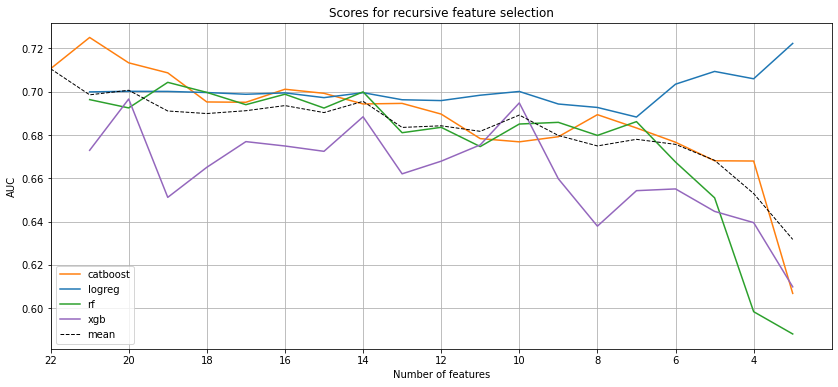

In [93]:
plt.figure(figsize=(14,6))
plt.plot(df_results["nr_features"], df_results["auc_catboost"], color="tab:orange", label="catboost")
plt.plot(df_results["nr_features"], df_results["auc_logreg"], color="tab:blue", label="logreg")
plt.plot(df_results["nr_features"], df_results["auc_rf"], color="tab:green", label="rf")
plt.plot(df_results["nr_features"], df_results["auc_xgb"], color="tab:purple", label="xgb")
plt.plot(df_results["nr_features"], df_results["auc_mean"], linestyle="--", linewidth=1, color="black", label="mean")
plt.xticks([x for x in range(22, 2, -2)])
plt.xlim([22, 2])
plt.title("Scores for recursive feature selection")
plt.xlabel("Number of features")
plt.ylabel("AUC")
plt.legend()
plt.grid()
plt.show()

### Final pick

In [96]:
logreg_10_features = pd.read_csv("data/model_scores/pick_10_features_catboost.csv", index_col=0)
logreg_10_features = logreg_10_features["feature_name"].tolist()

rf_10_features = pd.read_csv("data/model_scores/pick_10_features_rf.csv", index_col=0)
rf_10_features = rf_10_features["feature_name"].tolist()

catboost_10_features = pd.read_csv("data/model_scores/pick_10_features_catboost.csv", index_col=0)
catboost_10_features = catboost_10_features["feature_name"].tolist()

xgb_10_features = pd.read_csv("data/model_scores/pick_10_features_xgb.csv", index_col=0)
xgb_10_features = xgb_10_features["feature_name"].tolist()

# Model

In [125]:
df_scores = pd.DataFrame(columns=["training_time [s]", "accuracy", "precision", "recall", "f1", "auc"])

## 1. Logistic Regression

In [126]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [127]:
logreg = LogisticRegression(max_iter=2000)

X_resampled_logreg = X_resampled[logreg_10_features]
X_test_logreg = X_test[logreg_10_features]

start = time.time()
logreg.fit(X_resampled_logreg, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = logreg.predict(X_test_logreg)
y_proba = logreg.predict_proba(X_test_logreg)

df_scores.loc["logistic_regression"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]
df_scores

Elapsed time: 0.00 seconds


,training_time [s],accuracy,precision,recall,f1,auc
logistic_regression,0.0,0.728929,0.593023,0.377778,0.461538,0.698026


## 4. Random Forest

In [113]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [128]:
rf = RandomForestClassifier()

X_resampled_rf = X_resampled[rf_10_features]
X_test_rf = X_test[rf_10_features]

start = time.time()
rf.fit(X_resampled_rf, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = rf.predict(X_test_rf)
y_proba = rf.predict_proba(X_test_rf)

df_scores.loc["random_forest"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Elapsed time: 0 minutes 0.30 seconds


## 6. XGBoost

In [144]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [145]:
xg = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc", random_state=42, use_label_encoder=False)

X_resampled_xgb = X_resampled[xgb_10_features]
X_test_xgb = X_test[xgb_10_features]

start = time.time()
xg.fit(X_resampled_xgb, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = xg.predict(X_test_xgb)
y_proba = xg.predict_proba(X_test_xgb)

df_scores.loc["XGBoost"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Elapsed time: 0.10 seconds


## 7. CatBoost

In [136]:
X = df.drop(["wont_renew"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

X_train["chapter_ID"] = X_train["chapter_ID"].astype("str")
X_test["chapter_ID"] = X_test["chapter_ID"].astype("str")

cb = CatBoostClassifier(cat_features=["chapter_ID"])

X_train_cat = X_train[catboost_10_features]
X_test_cat = X_test[catboost_10_features]

start = time.time()
cb.fit(X_train_cat, y_train, early_stopping_rounds=20, verbose=200)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = cb.predict(X_test_cat)
y_proba = cb.predict_proba(X_test_cat)

df_scores.loc["CatBoost"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Learning rate set to 0.01309
0:	learn: 0.6894530	total: 30.5ms	remaining: 30.4s
200:	learn: 0.4938808	total: 5.5s	remaining: 21.8s
400:	learn: 0.4425014	total: 11.3s	remaining: 16.9s
600:	learn: 0.4044253	total: 16.6s	remaining: 11s
800:	learn: 0.3635921	total: 22.4s	remaining: 5.55s
999:	learn: 0.3254274	total: 28s	remaining: 0us
Elapsed time: minutes 28.21 seconds


## Compare results

In [146]:
df_scores.sort_values("auc", ascending=False)

,training_time [s],accuracy,precision,recall,f1,auc
logistic_regression,0.00,0.728929,0.593023,0.377778,0.461538,0.698026
random_forest,0.30,0.715262,0.555556,0.370370,0.444444,0.678472
XGBoost,0.10,0.681093,0.480315,0.451852,0.465649,0.670419
CatBoost,28.21,0.708428,0.552239,0.274074,0.366337,0.665960


In [147]:
df_scores.to_csv("model_scores_step6.csv")